# 🪙 Path of Exile 2 Economy Data Explorer

Note: This is generated with ChatGPT, to show an example of use.

This notebook downloads and caches market data from [poe.ninja](https://poe.ninja/poe2/economy/) using the `pyoe2_craftpath` library, parses it into an economy object, and provides tools to explore and visualize the results.

In [1]:
import os
import pandas as pd
import pyoe2_craftpath as pc

## Configuration

In [ ]:
MARKET_MAP = {
    "./cache/pn_abyss.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Abyss",
    "./cache/pn_currency.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Currency",
    "./cache/pn_essences.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Essences",
    "./cache/pn_ritual.json": "https://poe.ninja/poe2/api/economy/exchange/current/overview?league=Standard&type=Ritual"
}

CACHE_TTL_IN_SECONDS = 60 * 60  # 1 hour

os.makedirs("./cache", exist_ok=True)

## Fetch or Load Cached Data With Inbuilt Function

In [3]:
raw_fetched_responses = pc.retrieve_contents_from_urls_with_cache_unstable_order(
    cache_url_map=MARKET_MAP,
    max_cache_duration_in_sec=CACHE_TTL_IN_SECONDS
)

print(f"Loaded {len(raw_fetched_responses)} market data files.")

Loaded 4 market data files.
2025-11-12T17:56:20.054389Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_currency.json'
2025-11-12T17:56:20.060529Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_abyss.json'
2025-11-12T17:56:20.063800Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_ritual.json'
2025-11-12T17:56:20.066856Z  INFO retrieve_contents_from_urls_with_cache_unstable_order: Loading cached contents from './cache/pn_essences.json'


## Parse the Economy Data

In [4]:
economy = pc.PoeNinjaMarketPriceProvider.parse_from_json_list(
    raw_fetched_responses)

## Basic Validations

In [5]:
test_currency = economy.cache_market_prices.get(pc.ItemName("Perfect Orb of Transmutation"))
test_ritual = economy.cache_market_prices.get(pc.ItemName("Omen of the Blackblooded"))
test_essence = economy.cache_market_prices.get(pc.ItemName("Perfect Essence of Ruin"))
test_abyss = economy.cache_market_prices.get(pc.ItemName("Kulemak's Invitation"))

assert test_currency is not None
assert test_ritual is not None
assert test_essence is not None
assert test_abyss is not None

print("✅ Economy data loaded and validated successfully!")

✅ Economy data loaded and validated successfully!


## Example Conversions

In [6]:
assert test_currency is not None
assert test_ritual is not None
assert test_essence is not None
assert test_abyss is not None

print("Abyss Item Divine Value:", economy.currency_convert(
    test_abyss, pc.PriceKind.Divine))
print("Abyss Item Exalted Value:", economy.currency_convert(
    test_abyss, pc.PriceKind.Exalted))
print("Abyss Item Chaos Value:", economy.currency_convert(
    test_abyss, pc.PriceKind.Chaos))

Abyss Item Divine Value: 0.001234
Abyss Item Exalted Value: 2.068184
Abyss Item Chaos Value: 0.046892


## Convert Market Prices to DataFrame

In [7]:
data = [
    {
        "Item": str(item_name.raw_value), # (move out of wrapper to str)
        "Value (Divine)": price.get_divine_value(),
        "Value (Chaos)": economy.currency_convert(price, pc.PriceKind.Chaos),
        "Value (Exalted)": economy.currency_convert(price, pc.PriceKind.Exalted),
    }
    for item_name, price in economy.cache_market_prices.items()
]

df = pd.DataFrame(data).sort_values(by="Value (Divine)", ascending=False)
df.head(20)

,Item,Value (Divine),Value (Chaos),Value (Exalted)
122,Mirror of Kalandra,1738.0000,66044.000,2912888.000
106,Hinekora's Lock,683.0000,25954.000,1144708.000
139,Omen of Sinistral Annulment,7.3500,279.300,12318.600
87,Omen of Dextral Annulment,6.2100,235.980,10407.960
131,Ancient Collarbone,5.2300,198.740,8765.480
69,Omen of Sinistral Erasure,4.8200,183.160,8078.320
22,Omen of Chance,4.6900,178.220,7860.440
41,Omen of Whittling,3.8300,145.540,6419.080
126,Omen of Dextral Erasure,3.3600,127.680,5631.360
83,Ancient Jawbone,3.0900,117.420,5178.840


## Plot Top 20 Most Valuable Items (Divine Value)

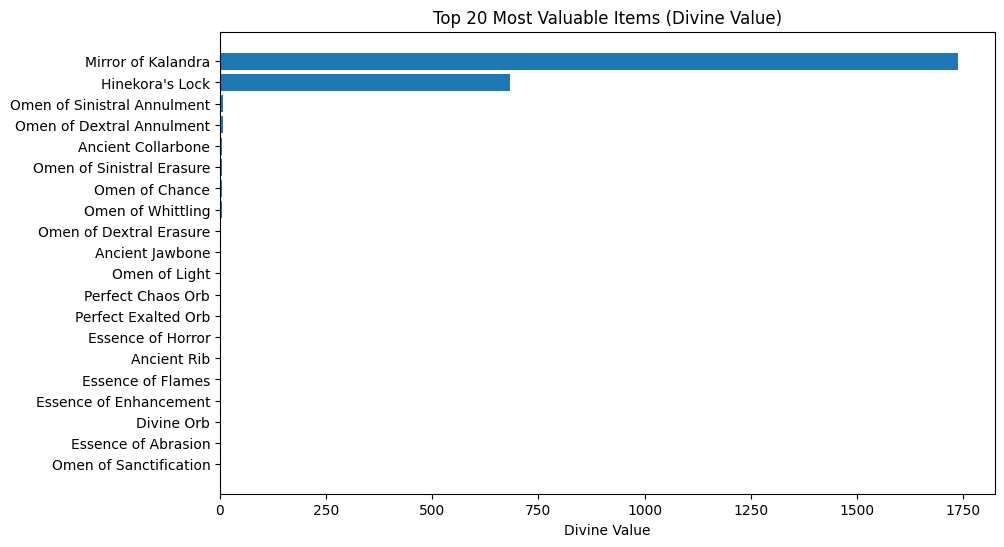

In [8]:
import matplotlib.pyplot as plt

top20 = df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top20["Item"], top20["Value (Divine)"])
plt.gca().invert_yaxis()
plt.xlabel("Divine Value")
plt.title("Top 20 Most Valuable Items (Divine Value)")
plt.show()

## Search Utility

In [9]:
def search_item(name_fragment: str):
    """Search for items by partial name."""
    return df[df["Item"].str.contains(name_fragment, case=False, na=False)]

# Example:
search_item("Divine")

,Item,Value (Divine),Value (Chaos),Value (Exalted)
19,Divine Orb,1.0,38.0,1676.0


## Interactive Exploration
You can re-run the search cell with different phrases like `"Essence"`, `"Omen"`, `"Orb"`, etc.